# Computer Vission Project

## Assignment 2

Professor previously uploaded file is little incorrect, this is the correct notebook please consider this.

to fix install rawpy problem, use python 3.8.8!!!!!!

In [10]:
import numpy as np
import rawpy
import matplotlib.pyplot as plt
import imageio
from scipy.signal import convolve2d
from PIL import Image as im
import cv2

In [11]:
def show(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def show_image_PIL(img_array):
    img = im.fromarray(img_array, 'RGB')
    img.show()
    
def fix_range(array):
    array = (array * 255).astype(np.uint8)
    return array

def min_max_norm(array):
    array = (array - np.min(array))/(np.max(array) - np.min(array))
    return array


def percentile_norm(array):
    a = np.percentile(array, 0.01)
    b = np.percentile(array, 99.99)
    normalized_data = (array - a) / (b - a)
    normalized_data[normalized_data < 0] = 0
    normalized_data[normalized_data > 1] = 1
    return normalized_data

## 1 Investigate Bayer Patterns

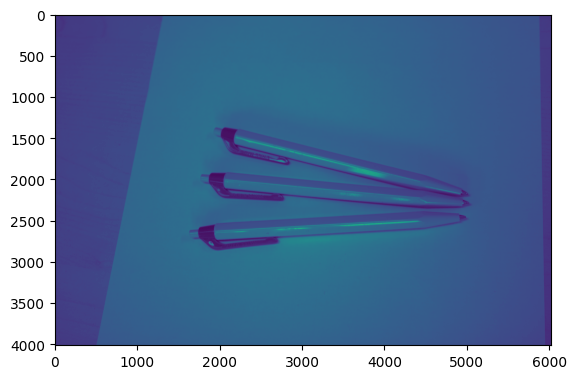

In [12]:
array = np.load('01/IMG_9939.npy')
plt.imshow(array)
plt.show()

In [13]:
print(array[:4,:4])  # the leading diagonal are green colored as there the values are maximum

[[3361 2596 3352 2614]
 [2829 3371 2854 3405]
 [3382 2614 3380 2608]
 [2833 3370 2894 3374]]


In [14]:
print(array[1396:1400, 2048:2052])   # Pixels at the tip of the red pen the values which are maximum must be red

# The remaining pixel is Blue

[[2309 2121 2311 2125]
 [2581 2287 2547 2289]
 [2282 2125 2282 2120]
 [2590 2293 2559 2296]]


Bayers pattern in the image pattern is:

Green   Blue <br>
Red     Green

## 2 Prove that sensor data is linear

In [15]:
raw = rawpy.imread("02/IMG_3044.CR3")
array = np.array(raw.raw_image_visible)

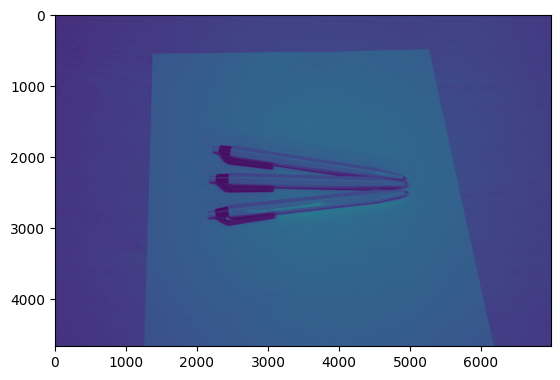

In [16]:
plt.imshow(array)
plt.show()

In [62]:
# Define the exposure times in seconds for each image
exposure_times = np.array([1/10, 1/20, 1/40, 1/80, 1/160, 1/320])

# Initialize arrays to store the average RGB values for each image
avg_red = []
avg_green = []
avg_blue = []
# Loop through each image file
for i in range(3044, 3050):
    # Construct the file name based on the image number
    file_name = f'02/IMG_{i}.CR3'
    # Read the raw image file
    with rawpy.imread(file_name) as raw:
        rgb = raw.raw_image_visible
        #print(rgb.shape)
        #print((rgb.shape[0]//2,rgb.shape[1]//2))
        green_mask=np.tile([[0,1],[1,0]],(rgb.shape[0]//2,rgb.shape[1]//2))
        red_mask=np.tile([[1,0],[0,0]],(rgb.shape[0]//2,rgb.shape[1]//2))
        blue_mask=np.tile([[0,0],[0,1]],(rgb.shape[0]//2,rgb.shape[1]//2))
        red_channel=rgb*red_mask
        green_channel=rgb*green_mask
        blue_channel=rgb*blue_mask

        # Calculate the average values for each channel
        avg_red.append(np.sum(red_channel.astype(np.uint64))/np.count_nonzero(red_channel))
        avg_green.append(np.sum(green_channel.astype(np.uint64))/np.count_nonzero(green_channel))
        avg_blue.append(np.sum(blue_channel.astype(np.uint64))/np.count_nonzero(blue_channel))

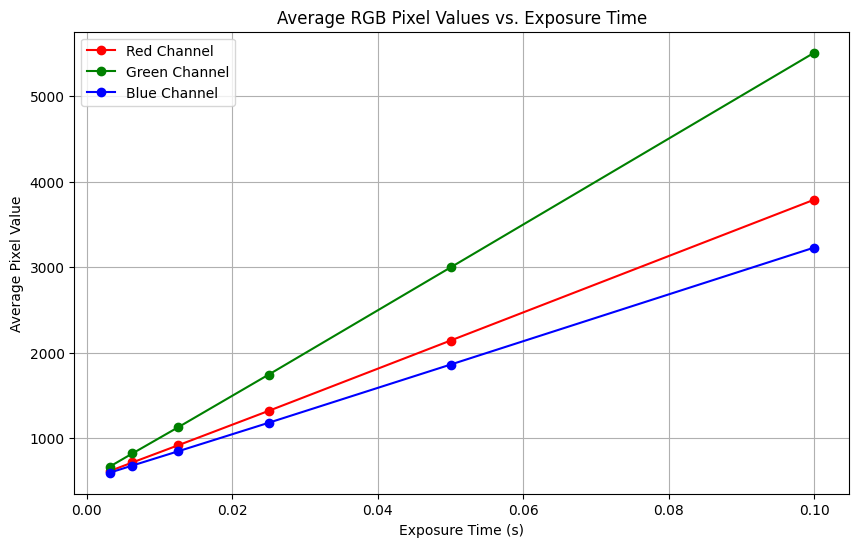

In [18]:
# Plot the average values against the exposure times
plt.figure(figsize=(10, 6))
plt.plot(exposure_times, avg_red, 'r-', label='Red Channel', marker = 'o')
plt.plot(exposure_times, avg_green, 'g-', label='Green Channel', marker = 'o')
plt.plot(exposure_times, avg_blue, 'b-', label='Blue Channel', marker = 'o')

# Add labels and title
plt.xlabel('Exposure Time (s)')
plt.ylabel('Average Pixel Value')
plt.title('Average RGB Pixel Values vs. Exposure Time')
plt.legend()
plt.grid(True)
plt.show()

## 3 Implement a Demosaicing Algorithm

In [19]:
def apply_demosaicing(sensor_data, normalize = False):
    # Convolution kernel for interpolation (3x3 averaging filter)
    kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    # Assuming RGB Bayer pattern
    mask_G=np.tile([[0,1],[1,0]],(sensor_data.shape[0]//2,sensor_data.shape[1]//2))
    mask_R=np.tile([[1,0],[0,0]],(sensor_data.shape[0]//2,sensor_data.shape[1]//2))
    mask_B=np.tile([[0,0],[0,1]],(sensor_data.shape[0]//2,sensor_data.shape[1]//2))

    # Apply the masks to the sensor data
    R = sensor_data * mask_R
    G = sensor_data * mask_G
    B = sensor_data * mask_B

    convolve1 = convolve2d(R, kernel, boundary='fill', mode='same', fillvalue=0)
    weights = convolve2d(mask_R, kernel, boundary='fill', mode='same', fillvalue=0)
    R  = convolve1/weights

    convolve1 = convolve2d(G, kernel, boundary='fill', mode='same', fillvalue=0)
    weights = convolve2d(mask_G, kernel, boundary='fill', mode='same', fillvalue=0)
    G = convolve1/weights

    convolve1 = convolve2d(B, kernel, boundary='fill', mode='same', fillvalue=0)
    weights = convolve2d(mask_B, kernel, boundary='fill', mode='same', fillvalue=0)
    B = convolve1/weights

    # Stack the channels together
    rgb_image = np.dstack((R, G, B))
    
    if normalize:
        # Normalize the data to the 8-bit range [0, 255]
        rgb_image = (rgb_image / rgb_image.max()) * 255

        # Cast to uint8 for displaying as an image
        rgb_image = np.clip(rgb_image, 0, 255).astype('uint8')

    return rgb_image

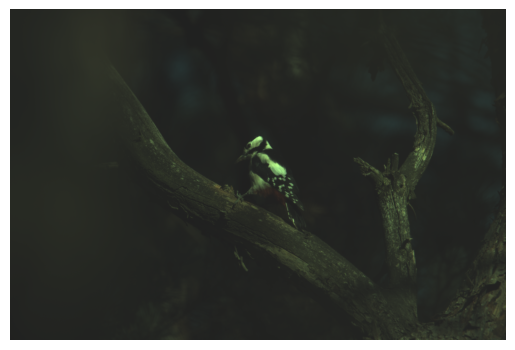

In [20]:
# Load the raw image data using rawpy
with rawpy.imread('03/IMG_4782.CR3') as raw:
    # Access the raw image data
    sensor_data = raw.raw_image_visible.copy()

rgb_image=apply_demosaicing(sensor_data, True)
# Display the resulting image
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis ticks
plt.show()


## 4 Improve Luminosity

In [21]:
def apply_gamma_correction(data, gamma):
    # Compute percentiles
    a = np.percentile(data, 0.01)
    b = np.percentile(data, 99.99)
    # Normalize data to [0, 1]
    normalized_data = (data - a) / (b - a)
    # Clip values to [0, 1]
    #normalized_data = np.clip(normalized_data, 0, 1)
    normalized_data[normalized_data < 0] = 0
    normalized_data[normalized_data > 1] = 1
    # Apply gamma correction
    gamma_corrected_data = normalized_data ** gamma
    data_corrected = fix_range(gamma_corrected_data)
    
    return data_corrected


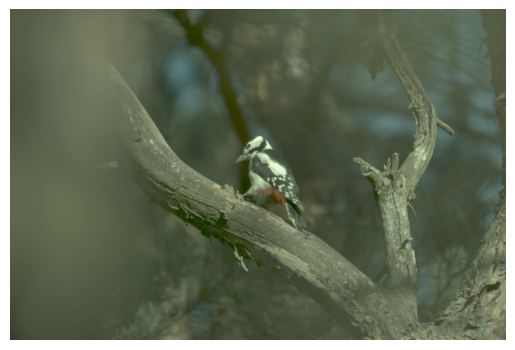

In [22]:
# Apply gamma correction
gamma_corrected_image = apply_gamma_correction(rgb_image, gamma=0.3)
# Display the resulting image
show(gamma_corrected_image)

In [23]:
def apply_gamma_correction_sin(data, gamma):
    # Compute percentiles
    a = np.percentile(data, 0.01)
    b = np.percentile(data, 99.99)
    # Normalize data to [0, 1]
    normalized_data = (data - a) / (b - a)
    # Clip values to [0, 1]
    #normalized_data = np.clip(normalized_data, 0, 1)
    normalized_data[normalized_data < 0] = 0
    normalized_data[normalized_data > 1] = 1
    # Apply gamma correction
    gamma_corrected_data = np.sin(normalized_data)
    data_corrected = fix_range(gamma_corrected_data)
    
    return data_corrected


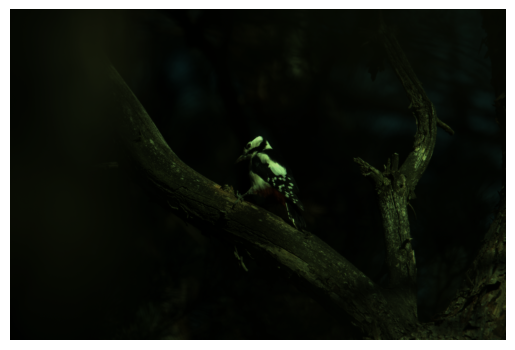

In [24]:
# Apply gamma correction
gamma_corrected_image_sin = apply_gamma_correction_sin(rgb_image, gamma=0.3)
# Display the resulting image
show(gamma_corrected_image_sin)

## 5 White Balance

In [25]:
def white_balance_gray_world(image_data):
    # Calculate the mean value for the whole image
    mi = np.mean(image_data)

    # Calculate the mean values for each channel
    mc_r = np.mean(image_data[:, :, 0])
    mc_g = np.mean(image_data[:, :, 1])
    mc_b = np.mean(image_data[:, :, 2])

    # Apply the Gray World algorithm for white balancing
    image_data[:, :, 0] = np.clip(image_data[:, :, 0] * (mi / mc_r), 0, 255)
    image_data[:, :, 1] = np.clip(image_data[:, :, 1] * (mi / mc_g), 0, 255)
    image_data[:, :, 2] = np.clip(image_data[:, :, 2] * (mi / mc_b), 0, 255)

    return image_data.astype(np.uint8)

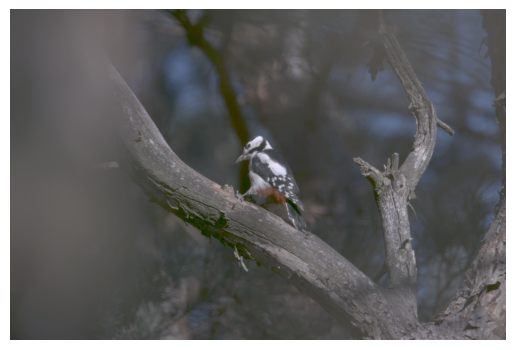

In [26]:
# Apply the white balance function to the gamma corrected image
white_balanced_image = white_balance_gray_world(gamma_corrected_image)

# Display the white-balanced image
plt.imshow(white_balanced_image)
plt.axis('off')  # Hide axis ticks
plt.show()


## 6 Initial HDR Implementation

In [27]:
def load_images(image_filenames, exposure_times):
    images = []
    for filename in image_filenames:
        with rawpy.imread(filename) as raw:
            images.append(raw.raw_image_visible.copy())
    return images, exposure_times


def create_hdr(images, exposure_times):
    hdr_image = images[0].astype(np.uint)
    for i in range(1,len(images)):
        threshold = 0.8 * np.max(hdr_image) 
        int_img = images[i].astype(np.uint) * (1/exposure_times[i])
        hdr_image[hdr_image > threshold] = int_img[hdr_image > threshold]
    
    return hdr_image

def save_image(image, filename):
    plt.imsave(filename, image)


HDR image:


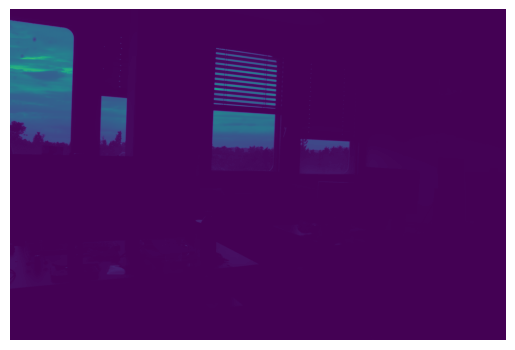

HDR image after applyign log scale:


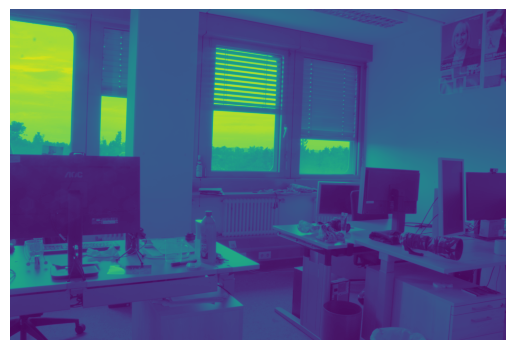

Image after applying demosaicing:


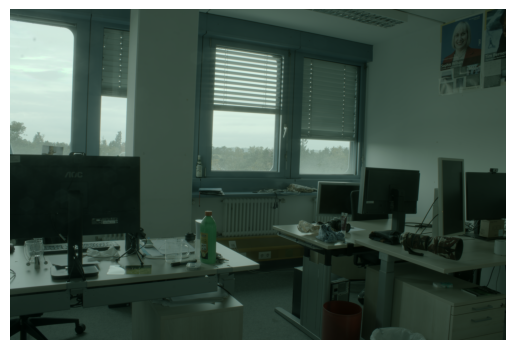

Image after applying Gray world white balancing:


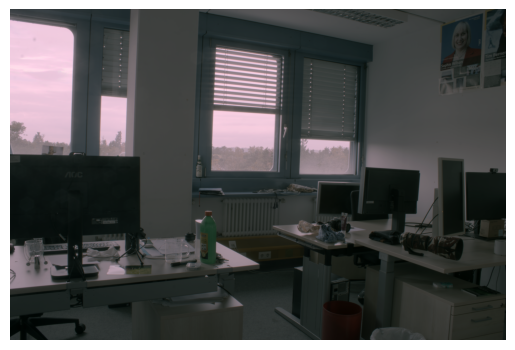

In [28]:
# Image filenames and corresponding exposure times
exposure_times = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024]
image_filenames = ['06/00.CR3', '06/01.CR3', '06/02.CR3', '06/03.CR3', '06/04.CR3', '06/05.CR3', '06/06.CR3', '06/07.CR3', '06/08.CR3', '06/09.CR3', '06/10.CR3']
# Load images
images, exposure_times = load_images(image_filenames, exposure_times)
# Create HDR image
hdr_image = create_hdr(images, exposure_times)
print("HDR image:")
show(hdr_image)
#apply log scaling
log_image = np.log(hdr_image)

print("HDR image after applyign log scale:")
show(log_image)

print("Image after applying demosaicing:")
demosaiced_img = apply_demosaicing(log_image, False)
normalized_image = percentile_norm(demosaiced_img)
# normalized_image = min_max_norm(demosaiced_img)
rgb_image = fix_range(normalized_image)
show(rgb_image)

print("Image after applying Gray world white balancing:")
hdr_image = white_balance_gray_world(rgb_image)
show(hdr_image)
save_image(hdr_image, 'hdr_final01.png')

## 7 iCAM06

In [29]:
def iCAM06(hdr_image, output_range=4):
    # Calculate input intensity as a weighted sum of the RGB channels
    input_intensity = (20*hdr_image[:,:,0] + 40*hdr_image[:,:,1] + hdr_image[:,:,2]) / 61

    # Normalise the image
    r, g, b = hdr_image[:,:,0] / input_intensity, hdr_image[:,:,1] / input_intensity, hdr_image[:,:,2] / input_intensity

    # Apply bilateral filter to the log of the input intensity
    log_base = cv2.bilateralFilter(np.log(input_intensity), d=9, sigmaColor=0.2, sigmaSpace=3)

    # Calculate the detail by subtracting the base from the log intensity
    log_detail = np.log(input_intensity) - log_base

    # Calculate compression factor
    compression = np.log(output_range) / (np.max(log_base) - np.min(log_base))

    # Calculate offset
    log_offset = -np.max(log_base) * compression

    # Calculate output intensity
    output_intensity = np.exp(log_base * compression + log_offset + log_detail)

    # Adjust the color channels
    hdr_image[:,:,0] = r * output_intensity
    hdr_image[:,:,1] = g * output_intensity
    hdr_image[:,:,2] = b * output_intensity

    # Normalize to 8-bit
    #hdr_image -= hdr_image.min()  # Shift data so the smallest value is 0
    #hdr_image /= hdr_image.max()  # Normalize the data to the range [0, 1]
    hdr_image *= 255  # Scale to the 8-bit range [0, 255]

    return hdr_image.astype(np.uint8)

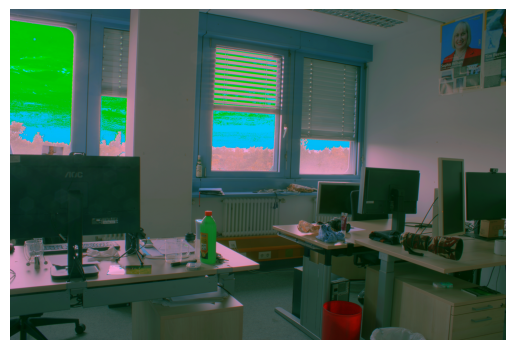

In [30]:
# Apply the iCAM06 algorithm
result_image = iCAM06(hdr_image.astype(np.float32))
result_image = apply_gamma_correction(result_image, 3)
# result_image = fix_range(min_max_norm(result_image))
show(result_image)
save_image(result_image, 'iCAM06_21.png')

## 8 Win

Increased the color saturation

In [31]:
def process_raw(raw_file_path, jpg_file_path):
    # Read the raw file
    raw = rawpy.imread(raw_file_path)
    sensor_data = raw.raw_image_visible.copy()       
    rgb_image = apply_demosaicing(sensor_data, False)
    gamma_image = apply_gamma_correction(rgb_image,0.3)
    processed_image = white_balance_gray_world(gamma_image)
    image = processed_image.astype(np.float32) / 255.0
    adjusted_image = cv2.convertScaleAbs(image, alpha=75, beta=-10)   
    hsv = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2HSV)

    # Increase the saturation channel
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * 1.6, 0, 255).astype(np.uint8)

    # Convert the image back to the BGR color space
    saturated_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    saturated_image = min_max_norm(saturated_image)
    saturated_image = fix_range(saturated_image)
    show(saturated_image)
        
    # Save the image as a high-quality JPG
    imageio.imsave(jpg_file_path, saturated_image, quality=98)

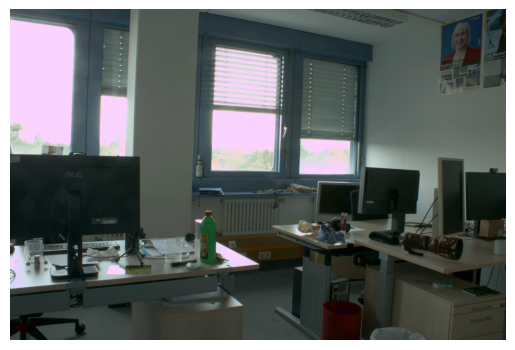

In [34]:
# Example usage

process_raw('/Users/melihekinci/Documents/FAU_Courses/ThirdSemester/Computer Vision/Week 2/exercise_2_data/06/02.CR3', 'compete08.jpg')

##  9 Additional Part

In [ ]:
# Path to your JPG files
directory = '/Users/melihekinci/Documents/FAU_Courses/ThirdSemester/Computer Vision/Week 2/exercise_2_data/hdr-jpg'

# Retrieve all JPG files and filter those in the range A45A6923.JPG to A45A6934.JPG
file_list = [file for file in os.listdir(directory) if file.endswith('.JPG')]
filtered_files = [file for file in file_list if 'A45A6923.JPG' <= file <= 'A45A6934.JPG']

# Sort the filtered files
sorted_files = sorted(filtered_files)

# Load all JPG images in the specified range
images = [Image.open(os.path.join(directory, file)) for file in sorted_files]

# Extract pixel values
pixel_values = [np.array(image) for image in images]


In [ ]:
# Each element in pixel_values is an image array with shape (height, width, channels)
average_values_red = []
average_values_green = []
average_values_blue = []

for img_array in pixel_values:
    # Calculate the average for each channel, excluding zero values
    avg_red = np.mean(img_array[:, :, 0])
    avg_green = np.mean(img_array[:, :, 1])
    avg_blue = np.mean(img_array[:, :, 2])
    # Store the average values
    #average_pixel_values.append((average_red, average_green, average_blue))
    average_values_red.append(avg_red)
    average_values_green.append(avg_green)
    average_values_blue.append(avg_blue)


In [ ]:
np.log(exposure_times)

array([ 2.56494936,  1.79175947,  1.16315081,  0.47000363, -0.22314355,
       -0.91629073, -1.60943791, -2.30258509, -2.99573227, -3.68887945,
       -4.38202663, -5.07517382])

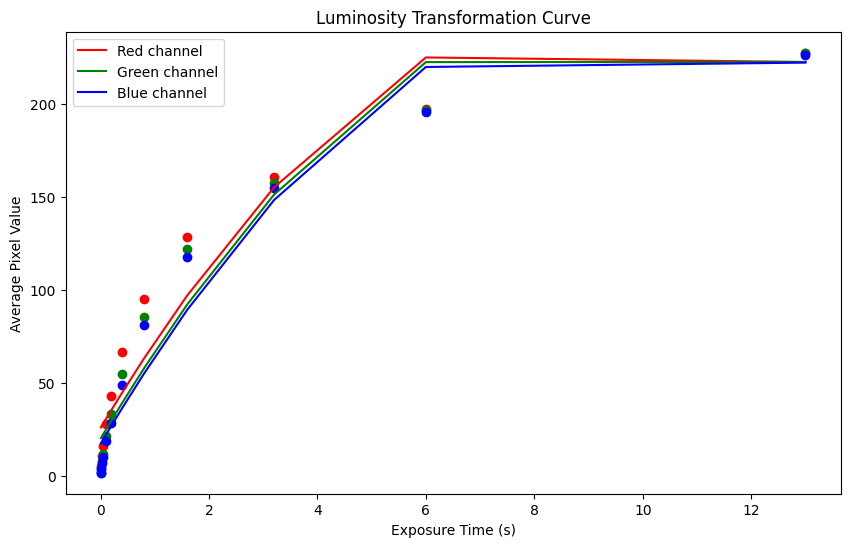

In [ ]:
from scipy.optimize import curve_fit

def polynomial_curve(x, a, b, c):
    return a * x**2 + b * x + c

# Assuming exposure times and average pixel values for each channel are known
#exposure_times = np.array([1/10, 1/20, 1/40, 1/80, 1/160, 1/320, 1/640, 1/1280, 1/2560, 1/5120, 1/10240, 1/20480])  # in seconds
exposure_times = np.array([13, 6, 3.2, 1.6, 0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625])  
#exposure_times = np.array([1/(2**i) for i in range(3, 15)])  
# Curve fitting for each color channel
params_red, _ = curve_fit(polynomial_curve, exposure_times, average_values_red)
params_green, _ = curve_fit(polynomial_curve, exposure_times, average_values_green)
params_blue, _ = curve_fit(polynomial_curve, exposure_times, average_values_blue)

params = [params_red, params_green, params_blue]

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.scatter(exposure_times, average_values_red, color='red')
plt.scatter(exposure_times, average_values_green, color='green')
plt.scatter(exposure_times, average_values_blue, color='blue')
plt.plot(exposure_times, polynomial_curve(exposure_times, *params_red), 'r-', label='Red channel')
plt.plot(exposure_times, polynomial_curve(exposure_times, *params_green), 'g-', label='Green channel')
plt.plot(exposure_times, polynomial_curve(exposure_times, *params_blue), 'b-', label='Blue channel')
plt.title("Luminosity Transformation Curve")
plt.xlabel("Exposure Time (s)")
plt.ylabel("Average Pixel Value")
plt.legend()
plt.show()


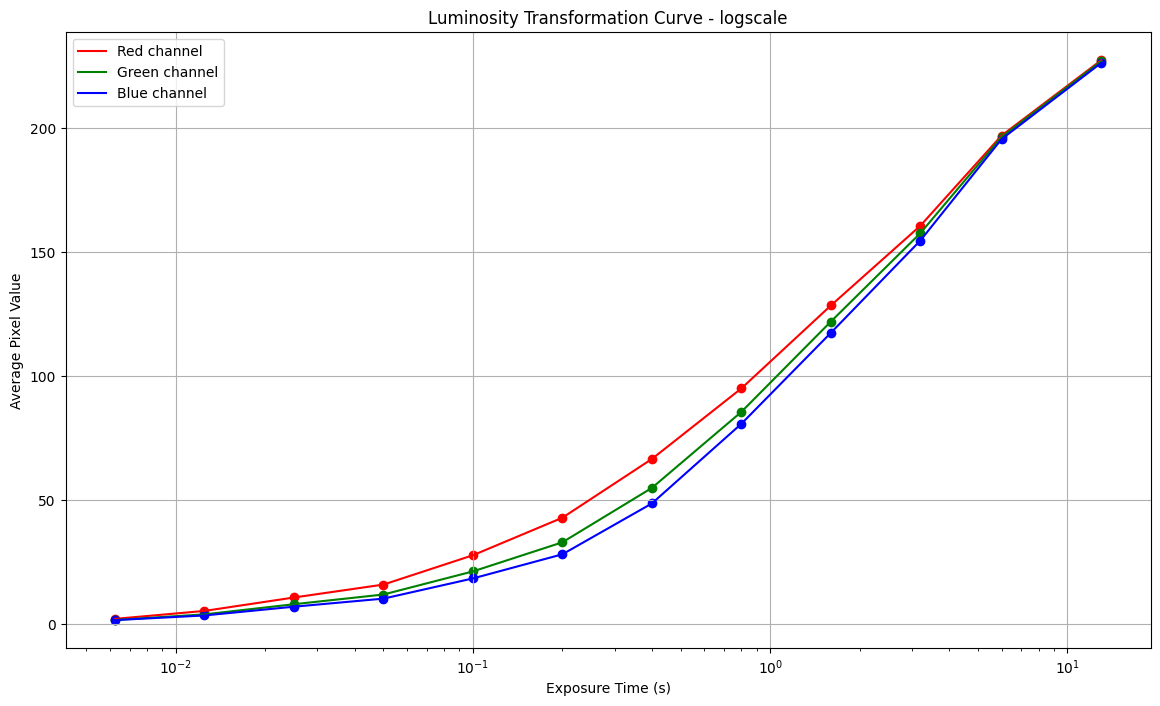

In [ ]:
# Plotting the luminosity transformation curves using the actual exposure times extracted from the images
plt.figure(figsize=(14, 8))
plt.plot(exposure_times, average_values_red, 'r-', label='Red channel')
plt.plot(exposure_times, average_values_green, 'g-', label='Green channel')
plt.plot(exposure_times, average_values_blue, 'b-', label='Blue channel')
plt.scatter(exposure_times, average_values_red, color='red')
plt.scatter(exposure_times, average_values_green, color='green')
plt.scatter(exposure_times, average_values_blue, color='blue')
plt.title("Luminosity Transformation Curve - logscale")
plt.xlabel("Exposure Time (s)")
plt.ylabel("Average Pixel Value")
plt.xscale('log')  # Set x-axis to logarithmic scale due to wide range of exposure times
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Inverse of the polynomial curve
# For a second-degree polynomial y = ax^2 + bx + c, the inverse can be calculated analytically
def inverse_polynomial_curve(y, a, b, c):
    # Calculating the discriminant
    discriminant = np.sqrt(b**2 - 4*a*(c - y))
    # Two solutions of the quadratic equation
    x1 = (-b + discriminant) / (2*a)
    x2 = (-b - discriminant) / (2*a)
    return x1, x2

In [ ]:
# Function to apply inverse transformation
def apply_inverse_transformation(image_array, params):
    # Ensure the image array is in float format
    transformed_image = np.zeros_like(image_array, dtype=float)
    
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            # Apply inverse transformation for each channel
            r, g, b = image_array[i, j]
            transformed_image[i, j, 0] = inverse_polynomial_curve(r, *params[0])[0]  # Red channel
            transformed_image[i, j, 1] = inverse_polynomial_curve(g, *params[1])[0]  # Green channel
            transformed_image[i, j, 2] = inverse_polynomial_curve(b, *params[2])[0]  # Blue channel

    # Clip values to the valid range and convert back to uint8
    transformed_image = np.clip(transformed_image, 0, 255).astype(np.uint8)
    return transformed_image


In [ ]:
def vectorized_inverse_transformation(image_array, params):
    # Ensure the image array is in float format
    transformed_image = np.zeros_like(image_array, dtype=float)

    # Separate the channels
    red_channel = image_array[:, :, 0]
    green_channel = image_array[:, :, 1]
    blue_channel = image_array[:, :, 2]

    # Calculate the discriminant for each channel
    discriminant_red = np.sqrt(params[0][1]**2 - 4*params[0][0]*(params[0][2] - red_channel))
    discriminant_green = np.sqrt(params[1][1]**2 - 4*params[1][0]*(params[1][2] - green_channel))
    discriminant_blue = np.sqrt(params[2][1]**2 - 4*params[2][0]*(params[2][2] - blue_channel))
    #print(discriminant_red,discriminant_green,discriminant_blue)
    # Calculate the inverse values for each channel
    transformed_image[:, :, 0] = (-params[0][1] + discriminant_red) / (2*params[0][0])  # Red channel
    transformed_image[:, :, 1] = (-params[1][1] + discriminant_green) / (2*params[1][0])  # Green channel
    transformed_image[:, :, 2] = (-params[2][1] + discriminant_blue) / (2*params[2][0])  # Blue channel

    # Clip values to the valid range and convert back to uint8
    transformed_image = np.clip(transformed_image, 0, 255).astype(np.uint8)

    return transformed_image


In [ ]:
import matplotlib.pyplot as plt

def plot_inverted_curves(params, title='Inverted RGB Curves'):
    # Generate a range of pixel values (0 to 255)
    pixel_values = np.linspace(0, 255, 256)

    # Calculate the inverse values for each channel
    inverse_red = [inverse_polynomial_curve(y, *params[0])[0] for y in pixel_values]
    inverse_green = [inverse_polynomial_curve(y, *params[1])[0] for y in pixel_values]
    inverse_blue = [inverse_polynomial_curve(y, *params[2])[0] for y in pixel_values]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(pixel_values, inverse_red, 'r-', label='Red Channel')
    plt.plot(pixel_values, inverse_green, 'g-', label='Green Channel')
    plt.plot(pixel_values, inverse_blue, 'b-', label='Blue Channel')
    plt.title(title)
    plt.xlabel('Original Pixel Value')
    plt.ylabel('Inverted Luminosity Value')
    plt.legend()
    plt.grid(True)
    plt.show()



/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_48645/3250848592.py:5: RuntimeWarning: invalid value encountered in sqrt
  discriminant = np.sqrt(b**2 - 4*a*(c - y))


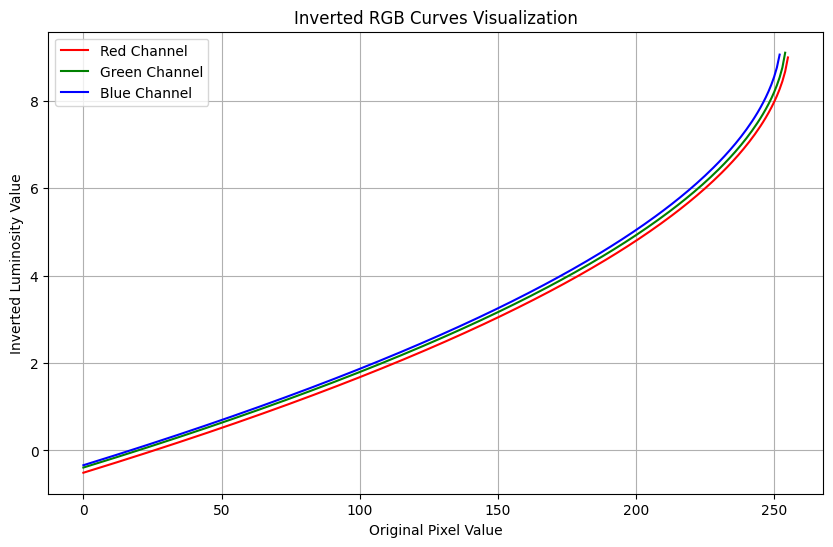

In [ ]:
# Call the function with the parameters
plot_inverted_curves(params, title='Inverted RGB Curves Visualization')


In [ ]:
# Test the new function with the same image
linear_image_vectorized = vectorized_inverse_transformation(pixel_values[0], params)

/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_48645/3060379608.py:12: RuntimeWarning: invalid value encountered in sqrt
  discriminant_green = np.sqrt(params[1][1]**2 - 4*params[1][0]*(params[1][2] - green_channel))
/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_48645/3060379608.py:13: RuntimeWarning: invalid value encountered in sqrt
  discriminant_blue = np.sqrt(params[2][1]**2 - 4*params[2][0]*(params[2][2] - blue_channel))
/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_48645/3060379608.py:21: RuntimeWarning: invalid value encountered in cast
  transformed_image = np.clip(transformed_image, 0, 255).astype(np.uint8)


In [ ]:

# Convert back to an image and save or display
linear_image_safe_jpg = Image.fromarray(linear_image_vectorized)
linear_image_safe_jpg.save('/Users/melihekinci/Documents/FAU_Courses/ThirdSemester/Computer Vision/Week 2/exercise_2_data/hdr-jpg/linear_image_vectorized.jpg')  # Save the image
linear_image_safe_jpg.show()  # Display the image


In [ ]:
def safe_inverse_transformation(image_array, params):
    # Ensure the image array is in float format
    transformed_image = np.zeros_like(image_array, dtype=float)

    # Separate the channels
    red_channel, green_channel, blue_channel = image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]

    # Function to calculate the inverse, with checks for negative discriminant
    def safe_inverse(y, a, b, c):
        discriminant = b**2 - 4*a*(c - y)
        if discriminant < 0:
            return 0  # or any default value you deem appropriate
        return (-b + np.sqrt(discriminant)) / (2*a)

    # Apply the safe inverse transformation for each channel
    np.vectorize(safe_inverse)(red_channel, *params[0])
    np.vectorize(safe_inverse)(green_channel, *params[1])
    np.vectorize(safe_inverse)(blue_channel, *params[2])

    # Clip values to the valid range and convert back to uint8
    transformed_image = np.clip(transformed_image, 0, 255).astype(np.uint8)

    return transformed_image

# Example usage with your image
linear_image_safe = safe_inverse_transformation(pixel_values[0], params)


In [ ]:
linear_image_safe_jpg = Image.fromarray(linear_image_safe)
linear_image_safe_jpg.save('/Users/melihekinci/Documents/FAU_Courses/ThirdSemester/Computer Vision/Week 2/exercise_2_data/hdr-jpg/linear_image_vectorized.jpg')  # Save the image
linear_image_safe_jpg.show()  # Display the image